In [89]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from neo import io
import quantities as pq

mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [122]:
# Import the list of files to analyse

ramps_df = pd.read_excel('C://Users//cdixon//Documents//DataSynaptopathies//20180410_AMPA_RampDetails.xlsx')
ramps_df.dropna(how='all', inplace=True)
summary_df = pd.read_excel('C://Users//cdixon//Documents//DataSynaptopathies//2017Electrophysiology/825RigBackup/GluR2_KA_summary100418.xlsx',
                              sheetname='Gria1')
summary_df['Record'] = summary_df['Record'].astype(str)
summary_df['Date'] = summary_df['Date'].astype(str)

def make_filenames(summary=summary_df, ramps_df=ramps_df):
    summary_df['File'] = 'blank'
    for row in range(0, len(summary_df)):
        summary_df['File'][row] = summary_df['Date'][row] + '_' + summary_df['Record'][row][:3]

make_filenames()
ramps_df = pd.merge(ramps_df, summary_df[['Mutant', 'File']], how='inner', on='File')
ramps_df.sort_values('Mutant', inplace=True) # Do this for graphing
ramps_df.reset_index(drop=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [58]:
ramps_df

,File,Date,number,ramp threshold,Analysis_start,Analysis_end,Notes,Mutant
0,180405_001,180405.0,1.0,-1300.0,30.0,90.0,NaN,T646N
1,180405_002,180405.0,2.0,-1000.0,25.0,90.0,NaN,T646N
2,180405_003,180405.0,3.0,-500.0,25.0,88.0,NaN,T646N
3,180405_006,180405.0,6.0,-1000.0,90.0,158.0,NaN,WT
4,180405_007,180405.0,7.0,-1000.0,45.0,105.0,NaN,WT
5,180405_009,180405.0,9.0,-1000.0,70.0,135.0,NaN,GRIA1
6,180405_010,180405.0,10.0,-500.0,20.0,110.0,NaN,GRIA1
7,180405_011,180405.0,11.0,-1500.0,35.0,125.0,NaN,A639S
8,180405_012,180405.0,12.0,-1000.0,33.0,100.0,NaN,A639S
9,180411_001,180411.0,1.0,-1500.0,70.0,140.0,NaN,T646N


In [133]:
class Cell:
    '''Loads the data for one cell, as defined in the summary dataframe'''
    def __init__(self, filepath, df, row):
        start_ms = int(df['Analysis_start'][row]-1)*1000
        end_ms = int(df['Analysis_end'][row]+2)*1000
        r = io.WinEdrIO(filename=filepath)
        seg = r.read_segment(lazy=False, cascade=True,)
        I = seg.analogsignals[0]
        self.I = I[start_ms:end_ms]         
        if end_ms > len(I):
            end_ms = len(I)
        print('total= ' , len(I), 'start=', start_ms, 'end=', end_ms)
        time = seg.analogsignals[0].times # warning: this can extend beyond the length of the recording;
        # can lead to len(t) > len(I)
        self.time = time[0:(end_ms - start_ms)] # In case the I is shorter than specified; need to keep t the same
   

Processing row  0
total=  103792 start= 29000 end= 92000
Found these jumps:  [1756, 3556, 6939, 8739, 10992, 12792, 18416, 20216, 22097, 23897, 25842, 27642, 34707, 36507, 38759, 40559, 42691, 44491, 51427, 53227, 54670, 56470, 58476, 60276]
Without duplicates:  [1756, 3556, 6939, 8739, 10992, 12792, 18416, 20216, 22097, 23897, 25842, 27642, 34707, 36507, 38759, 40559, 42691, 44491, 51427, 53227, 54670, 56470, 58476, 60276]
robust = [1756, 6939, 10992, 18416, 22097, 25842, 34707, 38759, 42691, 51427, 54670, 58476]
time len= 63000 I len= 63000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


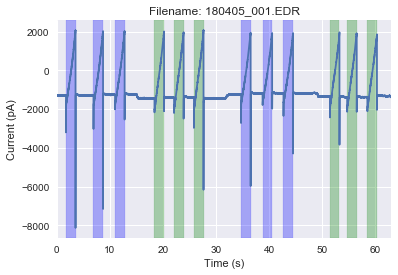

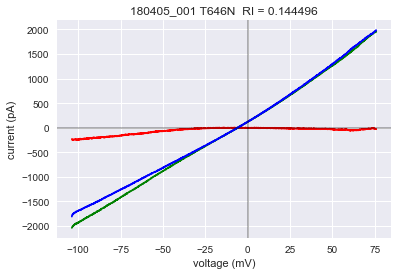

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: Length of values does not match length of index

In [140]:
# This needs refactoring
# Break into Process Cell independent of Batch process
# Also need to export subtracted ramp values as a csv for each cell

def batch_process(df=ramps_df, jump_threshold=50):
    df['RI'] = ''
    for row in range(0, len(df)): #len(df)
        print('Processing row ', row)
        filename = df['File'][row] + '.EDR'
        filepath = 'C:\\Users\\cdixon\\Documents\\DataSynaptopathies\\2018\\Glu\\' + filename
        cell = Cell(filepath, df, row)
        jumps = find_jumps(data=cell.I, threshold=jump_threshold)
        ramp_starts = ramp_start_robust(jumps)
        print('robust =', ramp_starts)
        drug_threshold = df['ramp threshold'][row]
        c_ramp_starts, d_ramp_starts = control_or_drug(cell.I, drug_threshold, ramp_starts) #this is not changing for the iterator
        print ('time len=', len(cell.time), 'I len=', len(cell.I))
        plot_trace(cell.time, cell.I, filename, c_ramp_starts, d_ramp_starts)
        subtracted = subtracted_ramp(cell.I, ramp_starts, drug_threshold)
        RI = rectification(subtracted) # 
        graph_final_ramps(cell.I, df['File'][row], df['Mutant'][row], subtracted, c_ramp_starts, d_ramp_starts, RI)#Is this really graphing new data???
        df['RI'][row] = RI
        print(filename, 'processed')
    df.to_excel('ramps_results.xlsx')

batch_process()

# Change the graph so that it still saves, but also outputs to a plt matrix (len(files)) then saves that as pdf.
# Make the data reader slice based on the specification file
#robust segment finder sometimes finds 2 overlapping segments. Need to skip more data points?

## Plotting data for visual inspection
User must choose threshold for control and drug periods and confirm appropriate data period.

After cutting out ramps, visually check that ramps are correctly identified, classified and averaged

In [61]:
#plot data
def plot_trace(time, I, filename, c_ramp_starts, d_ramp_starts):
    '''Plots the entire file by default. File can be subsectioned by passing an xscale tuple.
        Ramps are highlighted if the ramp identification functions have already been run'''
    try:
        plt.plot(time, I)
    except ValueError:
        print ("ValueError while plotting")
        pass
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pA)')
    #plt.ylim(yscale)
    plt.xlim(0, len(time)/1000)
    plt.title('Filename: %s' %filename)
    try:
        highlight_ramps(c_ramp_starts, color = 'b')
        highlight_ramps(d_ramp_starts, color = 'g')
    except NameError:
        pass
    return plt.show()

#Consider writing a function to identify the max and min in a sensible way? Median of the points either end of ramps?

# Remove the exceptions from the main function and add them in here

In [99]:

def find_jumps(data, threshold=50):
    '''returns a list of timepoints at which a large neg jump (amplitude defined by threshold) occured across 1ms'''
    jumps = []
    for point in range(0, len(data)-2):
        if int(data[point]) > (int(data[point+1])+threshold):
            jumps.append(point)
    print('Found these jumps: ', jumps)
    return jumps


def ramp_start(jumps):
    '''Identify adjacent pairs of start and end coordinates for ramps of 1800ms duration
    Requires points exactly 1800ms apart'''
    x = 0
    ramps = []
    while x < len(jumps)-1:
        if jumps[x]+1800 == jumps[x+1]:
            ramps.append(jumps[x])
        x = x+1
    return(ramps)


def highlight_ramps(ramp_starts, color = 'red'):
    '''Called in graph function to give visual feedback on where the ramps are identified'''
    for r in ramp_starts:
        plt.axvspan(r/1000, (r/1000)+1.8, color = color, alpha = 0.3)


In [102]:
###
test_jumps1 = [1000, 1001, 1010, 2800, 2801, 3000, 3100, 3300, 4800]
# Test that duplicates are removed
# Should remove any value that is within 100ms of it's predecessor
# Should catch multiple close values
    
def remove_duplicate_ramps(jumps):
    '''remove adjacent jumps that are too close together to be real'''
    x = 0
    remove = []
    while x < len(jumps)-1:
        for y in range(1, (len(jumps)-x -1)):
            if jumps[x+y] < jumps[x]+100:
                remove.append(jumps[x+y])
        x = x+1
    new_jumps = []
    for x in jumps:
        if x not in remove:
            new_jumps.append(x)
    print('Without duplicates: ', new_jumps)
    return(new_jumps)

remove_duplicate_ramps(test_jumps1)

Without duplicates:  [1000, 2800, 3000, 3100, 3300, 4800]


[1000, 2800, 3000, 3100, 3300, 4800]

In [136]:
   


test_jumps2 = [1000, 2800, 3000, 3300, 4800]
# test to ensure ramps are being found and spurious values ignored
# corrent return:
# [1000, 3000]
# test_jumps1 will return the same

def ramp_start_robust(jumps):
    '''Identify adjacent pairs of start and end coordinates for ramps of 1800ms duration
    Check each additional jump until run out of jumps or ramp is found'''
    jumps = remove_duplicate_ramps(jumps)
    x = 0
    ramps = []
    while x < len(jumps)-1:
        for y in range(1, (len(jumps)-x)):
            if jumps[x]+1800 == jumps[x+y]:
                ramps.append(jumps[x])
                break #Having found the end of the ramp, move to next x
            elif jumps[x]+1800 < jumps[x+y]:
                break #This x doesn't have a partner, so try the next x
            else:
                continue #May still have a partner, so keep trying more y
        x = x+1
    return(ramps)

ramp_start_robust(test_jumps1)

Without duplicates:  [1000, 2800, 3000, 3100, 3300, 4800]


[1000, 3000]

In [111]:

def control_or_drug(I, drug_threshold, ramp_starts):
    '''Pass in data as I'''
    control_ramp_starts = []
    drug_ramp_starts = []
    for r in ramp_starts:
        base = I[r-20].magnitude #use the first 20ms of the file for the baseline
        base = base[0]
        if base > drug_threshold:
            control_ramp_starts.append(r)
        else:
            drug_ramp_starts.append(r)
    return control_ramp_starts, drug_ramp_starts


def average_ramps(I, ramp_starts):
    '''pass in raw data as I and either drug or control ramp_starts list; will return average of those'''
    #Makes the first array before looping over the others that need averaging
    x = 1
    r = ramp_starts[0]
    av_ramp = I[r-1000:r+2800].magnitude
    for r in ramp_starts[1:]:
        #select I from r-1000 to r+2800 to catch the whole ramp
        seg = I[r-1000:r+2800].magnitude
        av_ramp = av_ramp + seg
        x = x+1
    return(av_ramp/x)


def subtracted_ramp(I, ramp_starts, drug_threshold):
    '''sorts ramps into drug category based on threshold then averages'''
    try:
        c_ramp_starts, d_ramp_starts = control_or_drug(I, drug_threshold, ramp_starts)
        subtracted = average_ramps(I, d_ramp_starts)-average_ramps(I, c_ramp_starts) 
    except IndexError:
        print ('Index error in ramps')
        subtracted = 'NaN'
    return subtracted


#Need to split out a table with the rectification ratio,
#1 graph with all 3 lines
#Plot the control, drug and subtraction curves

def graph_final_ramps(I, recordname, mutant, subtracted, c_ramp_starts, d_ramp_starts, RI):
    '''Saves and outputs plot of control drug and subtracted ramps'''
    mV_ms = 180/1800
    x_ms = np.array(range(0,1800))
    x_mV = (x_ms*mV_ms)-104
    #-100 because the ramp started at -100, then also -4 to correct for LJP
    fig, ax = plt.subplots()
    plt.plot(x_mV[2:], subtracted[1002:2800], 'r')
    plt.plot(x_mV[2:], average_ramps(I, d_ramp_starts)[1002:2800], 'g')
    plt.plot(x_mV[2:], average_ramps(I, c_ramp_starts)[1002:2800], 'b')
    plt.axhline(0, color='black', alpha=0.3)
    plt.axvline(0, color='black', alpha=0.3)
    plt.xlabel('voltage (mV)')
    plt.ylabel('current (pA)')
    plt.title(recordname + ' ' + mutant + '  RI = ' + str(RI)) #added 8/5/18
    save_name = recordname + 'RampGraph.pdf'
    plt.savefig(save_name, transparent=True)
    return plt.show()

#graph_final_ramps()
#Write a wrapper code that puts out filename and rect ratio for each cell

def rectification(subtracted, pos=40, neg=-70):
    '''finds the ratio of currents at specified positive and negative voltages'''
    if subtracted == 'NaN':
        RI = 'NaN'
        print('Not possible to find RI')
    else:
        pos_xindex = 10*(pos+104)+1000 # *10 needed because mV/ms is 10. 1000 adjusts for baseline at the start
        neg_xindex = 10*(neg+104)+1000
        pos = subtracted[pos_xindex]
        neg = subtracted[neg_xindex]
        rectification_index = pos/neg
        RI = rectification_index[0]
    return RI
    
#rectification()

#No point doing all this until I figure out how to make the text editable in Python

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

## Plot each ramp individually to look for abnormalities

Not usually neccessary

In [ ]:
#Need to generate a whole pile of plots in one figure
#Requires holding it in memory then outputting at the end of the for loop

#Number of plots: len(df), 2, x

p = 1
plt.subplots(len(df), 2, p)

#in for loop:


In [16]:
#Extra plots to visually confirm that the subtraction is fine
#Plot each of the ramps identified, based on control or drug

c_ramp_starts, d_ramp_starts = control_or_drug()

x = 1

for n in c_ramp_starts:
    plt.subplot(3, 6, x)#Need to change this to adjust to the number of control/drug traces
    plt.plot(I[n-1000:n+2800], color = 'b')
    plt.ylim(-5000, 4000)
    x += 1

for n in d_ramp_starts:
    plt.subplot(3, 6, x)
    plt.plot(I[n-1000:n+2800], color = 'g')
    plt.ylim(-5000, 4000)
    x += 1

n = subtracted_ramp()
plt.subplot(3,6,x)
plt.plot(n, color = 'r')
plt.ylim(-5000, 4000)



TypeError: control_or_drug() missing 3 required positional arguments: 'I', 'drug_threshold', and 'ramp_starts'


## Spare code: Everything below here is not necessary for current functionality

In [ ]:
#plt.figure(figsize=(20,3))
#plt.plot(time[0:20000], I[0:20000])

sampling_rate = 1000

def convert(sec, sampling_rate = sampling_rate):
    '''Converts time(s) to number of samples'''
    return sec*sampling_rate

def section(from_s, to_s, sampling_rate = sampling_rate, time_array = time, data_array = I):
    '''Takes a slice of recording defined by start and end times (from_s, to_s)'''
    return(time_array[convert(from_s):convert(to_s)], data_array[convert(from_s):convert(to_s)])

def plot_section(from_s, to_s, sampling_rate = sampling_rate, time_array = time, data_array = I):
    '''Plots a section of recording defined by start and end times (from_s, to_s)'''
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pA)')
    plt.title('Filename: %s' %filename)
    return plt.plot(time_array[convert(from_s):convert(to_s)], data_array[convert(from_s):convert(to_s)])

plot_section(1, 100)


In [ ]:
#how to return an array to be subtracted on?
av_ramp = []
av_ramp = I[0:1000].magnitude
av_ramp + I[1000:2000].magnitude
av_ramp.shape

In [ ]:
I[0].magnitude/2


In [ ]:

def find_zero(data):
    '''returns a list of timepoints at which a large neg jump occured'''
    crossings = []'
    for point in range(0, len(data)):
        if data[point] == 0:
            crossings.append(point)
    return crossings


In [ ]:
base = np.mean(I[1:500])
print (base)
test_section = section(50, 60)

#ugly brute force approach to find zeros

def zero_crossing(base, data = I):
    mask = []
    for point in I:
        if -1 <= point[0] <= 0 :
            mask.append[point]
        return mask
        
zero_crossing(test_section)
    

    

From when i was analysing one at a time:

# Identify file
filepath = 'C:\\Users\\cdixon\\Documents\\DataSynaptopathies\\2018\\Glu\\180320_008.EDR'

# Names to use in graphs and outputs
# folder = filepath.split('\\')[0:-1] #This won't work as it will return a list not a string
filename = filepath.split('\\')[-1]
recordname = filename.split('.')[-2]

# read in file
# for Neo info see Garcia et al., 2014
r = io.WinEdrIO(filename=filepath)
seg = r.read_segment(lazy=False, cascade=True,)

# make data series
time = seg.analogsignals[0].times
I = seg.analogsignals[0]

In [ ]:
#strip units from the array using magnitude attribute

a = I.magnitude
pA = pd.DataFrame(a)

#add time as the index value
#filter to find first instance of jump
#make a list of the jump time points
#iterate over list, pulling out chunks of data for each ramp
#Classify each ramp into High or Low baseline
#average each high and each low pile
#graph the averages on top of each other:
#convert x axis from time into voltage using the v/s algorithm + ljp X offset

In [ ]:
base.magnitude

In [ ]:
d = pA.diff(1)

In [ ]:
siglist = seg.analogsignals
time_points = siglist[0].times
#avg = np.mean(siglist, axis=0) # Average over signals of Segment

plt.figure()
#plt.plot(time_points, avg)
plt.plot(time_points, siglist[0])

time_points = seg.analogsignals[0].times
data_points = seg.analogsignals[0]
plt.figure()
plt.plot(time_points, data_points)

In [ ]:
Y = (seg.analogsignals[0])
X = siglist[0].times

In [ ]:
import math

import matplotlib.pyplot as plt

class AnnoteFinder(object):
    """callback for matplotlib to display an annotation when points are
    clicked on.  The point which is closest to the click and within
    xtol and ytol is identified.
    
    Register this function like this:
    
    scatter(xdata, ydata)
    af = AnnoteFinder(xdata, ydata, annotes)
    connect('button_press_event', af)
    """

    def __init__(self, xdata, ydata, annotes, ax=None, xtol=None, ytol=None):
        self.data = list(zip(xdata, ydata, annotes))
        if xtol is None:
            xtol = ((max(xdata) - min(xdata))/float(len(xdata)))/2
        if ytol is None:
            ytol = ((max(ydata) - min(ydata))/float(len(ydata)))/2
        self.xtol = xtol
        self.ytol = ytol
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.drawnAnnotations = {}
        self.links = []

    def distance(self, x1, x2, y1, y2):
        """
        return the distance between two points
        """
        return(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))

    def __call__(self, event):

        if event.inaxes:

            clickX = event.xdata
            clickY = event.ydata
            if (self.ax is None) or (self.ax is event.inaxes):
                annotes = []
                # print(event.xdata, event.ydata)
                for x, y, a in self.data:
                    # print(x, y, a)
                    if ((clickX-self.xtol < x < clickX+self.xtol) and
                            (clickY-self.ytol < y < clickY+self.ytol)):
                        annotes.append(
                            (self.distance(x, clickX, y, clickY), x, y, a))
                if annotes:
                    annotes.sort()
                    distance, x, y, annote = annotes[0]
                    self.drawAnnote(event.inaxes, x, y, annote)
                    for l in self.links:
                        l.drawSpecificAnnote(annote)

    def drawAnnote(self, ax, x, y, annote):
        """
        Draw the annotation on the plot
        """
        if (x, y) in self.drawnAnnotations:
            markers = self.drawnAnnotations[(x, y)]
            for m in markers:
                m.set_visible(not m.get_visible())
            self.ax.figure.canvas.draw_idle()
        else:
            t = ax.text(x, y, " - %s" % (annote),)
            m = ax.scatter([x], [y], marker='d', c='r', zorder=100)
            self.drawnAnnotations[(x, y)] = (t, m)
            self.ax.figure.canvas.draw_idle()

    def drawSpecificAnnote(self, annote):
        annotesToDraw = [(x, y, a) for x, y, a in self.data if a == annote]
        for x, y, a in annotesToDraw:
            self.drawAnnote(self.ax, x, y, a)

In [ ]:
#x = range(10)
#y = range(10)
#annotes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

fig, ax = plt.subplots()
ax.scatter(x,y)
af =  AnnoteFinder(x,y, annotes, ax=ax)
fig.canvas.mpl_connect('button_press_event', af)
plt.show()

http://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/